In [55]:
%config Completer.use_jedi = False

In [26]:
%config Completer.use_jedi = True

In [23]:
# Import Libraries
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import shap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [5]:
# Load Data
df_train = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/train.csv")
df_test = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/test.csv")
df_data_dict = pd.read_csv("/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv")

In [4]:
df_train.head()

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


In [6]:
# Show the head of the data_dict
df_data_dict.head()

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN


In [7]:
# Show the shape of the data_dict
df_data_dict.shape

(59, 4)

In [8]:
# Show the number of type values
df_data_dict["type"].value_counts()

type
Categorical    36
Numerical      23
Name: count, dtype: int64

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [10]:
# Numerical Features
num_cols = \
    df_data_dict.query("type == 'Numerical'")["variable"].to_list()
print(num_cols)

['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'donor_age', 'hla_match_b_low', 'age_at_hct', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'efs_time']


In [11]:
# Categorical Features
cat_cols = \
    df_data_dict.query("type == 'Categorical'")["variable"].to_list()
print(cat_cols)

['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'efs']


In [17]:
# Show the Correlations
df_train[num_cols+["efs"]].corr(method="spearman").sort_values(by="efs")

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,efs_time,efs
efs_time,0.022269,0.026656,0.015745,0.025985,0.021514,0.012581,0.029183,0.034575,-0.007695,0.011532,...,-0.173477,0.041624,0.033254,-0.169469,0.131331,0.021245,-0.008801,0.019033,1.000000,-0.854608
year_hct,-0.165940,-0.167172,-0.165581,-0.160990,-0.157647,-0.118577,-0.148437,-0.161431,-0.153395,-0.120193,...,-0.002273,-0.144055,-0.153105,0.087344,-0.021893,-0.169952,-0.152857,-0.164340,-0.127900,-0.111288
karnofsky_score,-0.021133,-0.035744,-0.045764,-0.040003,-0.041471,-0.036979,-0.043543,-0.021491,-0.058323,-0.036946,...,-0.225969,-0.027970,-0.019760,-0.176462,1.000000,-0.042145,-0.051808,-0.048056,0.131331,-0.095293
hla_match_a_low,0.600850,0.767487,0.866286,0.773994,0.758812,0.549215,0.789948,0.602518,0.646207,0.507520,...,0.022552,1.000000,0.632686,0.013560,-0.027970,0.845052,0.657811,0.827219,0.041624,0.014448
hla_match_a_high,0.582152,0.835034,0.760093,0.852039,0.816996,0.540448,0.776006,0.588191,0.625989,0.507189,...,0.028180,0.773548,0.624551,0.016968,-0.031613,0.751957,0.636090,0.745978,0.043460,0.014572
hla_match_c_low,0.763150,0.753975,0.734740,0.732501,0.750171,0.623844,0.712726,1.000000,0.696079,0.597883,...,-0.024565,0.602518,0.724441,-0.024252,-0.021491,0.813240,0.695412,0.799049,0.034575,0.016010
hla_match_b_high,0.722908,0.870143,0.763559,0.872385,0.851387,0.613872,0.741941,0.724441,0.689565,0.576801,...,-0.013516,0.632686,1.000000,-0.013168,-0.019760,0.781454,0.710073,0.780986,0.033254,0.026131
hla_match_c_high,1.000000,0.798161,0.726872,0.726420,0.781402,0.629183,0.706515,0.763150,0.697563,0.611841,...,-0.018349,0.600850,0.722908,-0.033271,-0.021133,0.746018,0.700355,0.745326,0.022269,0.032399
hla_match_dqb1_low,0.611841,0.632537,0.621898,0.619725,0.648812,0.608899,0.609515,0.597883,0.619952,1.000000,...,0.018958,0.507520,0.576801,-0.036671,-0.036946,0.630376,0.621037,0.741613,0.011532,0.032519
hla_match_dqb1_high,0.629183,0.671300,0.668209,0.660082,0.778352,1.000000,0.647041,0.623844,0.666231,0.608899,...,0.028155,0.549215,0.613872,-0.039891,-0.036979,0.674659,0.656439,0.689202,0.012581,0.040572


In [13]:
# Compare the difference between Nan and Non Nan values, by conducting chi squared tests
for col in num_cols:
    mean_nan = df_train.query(f"~{col}.isnull()")["efs"].mean()
    mean_non_nan = df_train.query(f"{col}.isnull()")["efs"].mean()

    print(col, mean_nan, mean_non_nan)

hla_match_c_high 0.5366832092638544 0.553030303030303
hla_high_res_8 0.5382438727090679 0.5434894493051982
hla_low_res_6 0.5405013709361536 0.5299694189602446
hla_high_res_6 0.5380591937404321 0.5448523845571537
hla_high_res_10 0.5334380921569534 0.5570291777188329
hla_match_dqb1_high 0.5303588830981738 0.5799192152336988
hla_nmdp_6 0.5406251270170305 0.5315701691684537
hla_match_c_low 0.5371153846153847 0.5596428571428571
hla_match_drb1_low 0.5400848721183622 0.5315928868709799
hla_match_dqb1_low 0.5309274160773795 0.5884597043395327
year_hct 0.5393055555555556 nan
hla_match_a_high 0.5368790562880118 0.5531271797256452
donor_age 0.5534232365145229 0.32853982300884954
hla_match_b_low 0.539660758528683 0.5356725146198831
age_at_hct 0.5393055555555556 nan
hla_match_a_low 0.5400227186671716 0.5313807531380753
hla_match_b_high 0.5357316283586921 0.5609099804305284
comorbidity_score 0.5391024962044981 0.5513626834381551
karnofsky_score 0.543000358037952 0.4206896551724138
hla_low_res_8 0.53

In [14]:
# Chi Squared Test for Nan or Non Nan
for col in num_cols:
    tf_int_nan = df_train[col].isnull().astype("int")
    crossed = pd.crosstab(df_train["efs"], tf_int_nan)

    if df_train[col].isnull().sum() == 0:
        continue
    x2, p, dof, expected = sp.stats.chi2_contingency(crossed)
    print(col, p)

hla_match_c_high 0.04272086048476359
hla_high_res_8 0.4821482684712375
hla_low_res_6 0.26315528697137236
hla_high_res_6 0.3789016904768512
hla_high_res_10 0.0005436396178033859
hla_match_dqb1_high 9.509556130960789e-11
hla_nmdp_6 0.2841697730148889
hla_match_c_low 0.024302800861595298
hla_match_drb1_low 0.41551410765756946
hla_match_dqb1_low 5.485208467650453e-12
hla_match_a_high 0.05056876707644851
donor_age 8.554327077391529e-77
hla_match_b_low 0.7143562488827826
hla_match_a_low 0.42939016097186333
hla_match_b_high 0.0029322490649142125
comorbidity_score 0.6266735697312742
karnofsky_score 1.3123423858616949e-12
hla_low_res_8 0.6807317185035768
hla_match_drb1_high 0.1378547600422131
hla_low_res_10 0.002474452024990562


<Axes: >

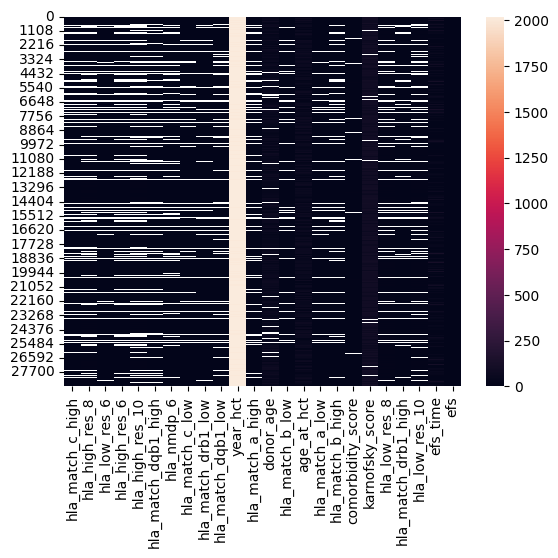

In [15]:
# Plot a heatmap
sns.heatmap(df_train[num_cols+["efs"]])

In [16]:
# Plot the differences between categorical features
for col in cat_cols:
    print(df_train.groupby([col]).agg({"efs":"mean", "efs_time":"count"}))

                                                        efs  efs_time
dri_score                                                            
High                                               0.705807      4701
High - TED AML case <missing cytogenetics          0.586987      1414
Intermediate                                       0.587677     10436
Intermediate - TED AML case <missing cytogenetics  0.550936       481
Low                                                0.593458      1926
Missing disease status                             0.555556         9
N/A - disease not classifiable                     0.367647       272
N/A - non-malignant indication                     0.388546      2427
N/A - pediatric                                    0.389831      4779
TBD cytogenetics                                   0.392411      2003
Very high                                          0.404040       198
                    efs  efs_time
psych_disturb                    
No             0.52375

In [18]:
# Conduct chi square test with the categorical features
for col in cat_cols:
    if col == "efs":
        continue
        
    crossed = df_train.pivot_table(index="efs", columns=col, aggfunc="count", values="efs_time")
    x2, p, dof, expected = sp.stats.chi2_contingency(crossed)
    print(col, p)

dri_score 0.0
psych_disturb 1.2979884206277078e-26
cyto_score 0.0017695925410587407
diabetes 9.473517746062939e-31
tbi_status 3.8722021216188026e-17
arrhythmia 1.4455281691857336e-13
graft_type 0.0
vent_hist 0.5894941475545321
renal_issue 0.0008044609682586675
pulm_severe 1.1740716320072957e-38
prim_disease_hct 0.0
cmv_status 2.9962065563817596e-63
tce_imm_match 0.0034450120733785987
rituximab 0.38833316629745207
prod_type 0.0
cyto_score_detail 2.230345526681301e-39
conditioning_intensity 8.244812565600893e-75
ethnicity 1.3456203538403933e-12
obesity 3.0830353189626647e-11
mrd_hct 0.0029375088750194715
in_vivo_tcd 2.2959109320915427e-169
tce_match 7.401409152266465e-06
hepatic_severe 1.5564351873948722e-43
prior_tumor 1.6392138057148042e-59
peptic_ulcer 7.371145089197224e-05
gvhd_proph nan
rheum_issue 0.14867597064259122
sex_match 2.4603059525281827e-45
race_group 1.3172052971466758e-58
hepatic_mild 0.00712901221944448
tce_div_match 1.8542188641433027e-05
donor_related 1.68288255553108

In [19]:
# See the realations between numerical features and the target value
# Plot 

## Create a Basic Machine Learning Model

In [20]:
# Define Data
X = df_train.drop(columns=["ID", "efs", "efs_time"])
y = df_train[["efs"]]

In [21]:
# Convert categorical features by conducting label encoding
for col in cat_cols:
    if col == "efs":
        continue
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [22]:
# Split the Data Sets into train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [23]:
# Train with basic light GBDT Models
cat_model = cat.CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=cat_pred))

ROC AUC: 0.7545325187056697


In [24]:
cat_feat_cols = cat_cols.copy()
cat_feat_cols.remove("efs")

In [25]:
# Train with basic GBDT Models
cat_model = cat.CatBoostClassifier(verbose=0, cat_features=cat_feat_cols)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=cat_pred))

ROC AUC: 0.7592474977204087


100%|===================| 7170/7200 [03:52<00:00]        

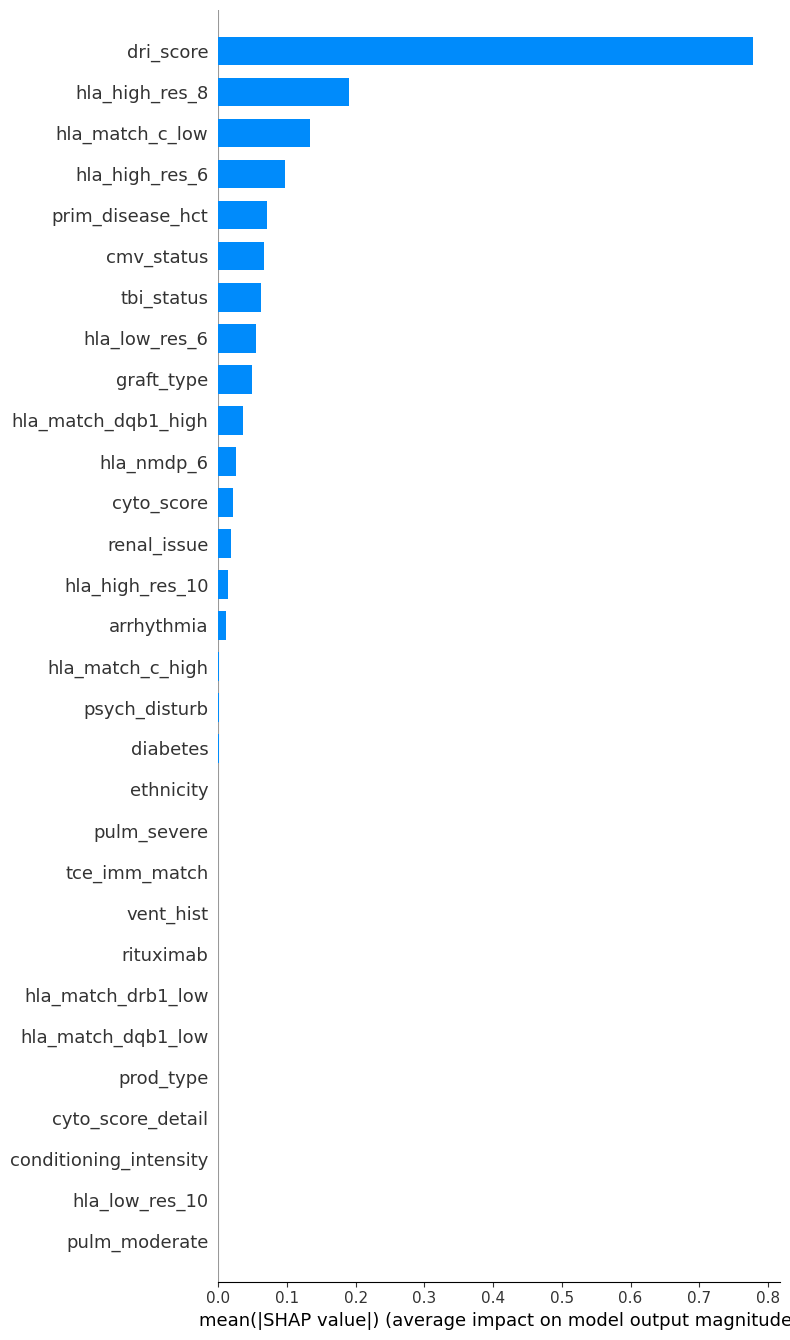

In [35]:
# Plot Important Features for the Catboost Model
explainer = shap.TreeExplainer(model=cat_model, data=X_test)
shap_values = explainer.shap_values(X=X_test)
shap.summary_plot(shap_values=shap_values, features=X_test, plot_type="bar", max_display=30)

In [36]:
def plot_shap(model, X_test):
    """
    Plot a summary plot of the shap values
    """
    explainer = shap.TreeExplainer(model=model, data=X_test)
    shap_values = explainer.shap_values(X=X_test)
    shap.summary_plot(shap_values=shap_values, features=X_test, plot_type="bar", max_display=30)

In [37]:
# Train with basic light GBDT Models
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=lgb_pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Number of positive: 11690, number of negative: 9910
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 21600, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541204 -> initscore=0.165189
[LightGBM] [Info] Start training from score 0.165189
ROC AUC: 0.7482200431021787


In [42]:
# Train with basic XGBoost Model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=xgb_pred))

ROC AUC: 0.7342676040093521


 98%|===================| 7067/7200 [00:39<00:00]        

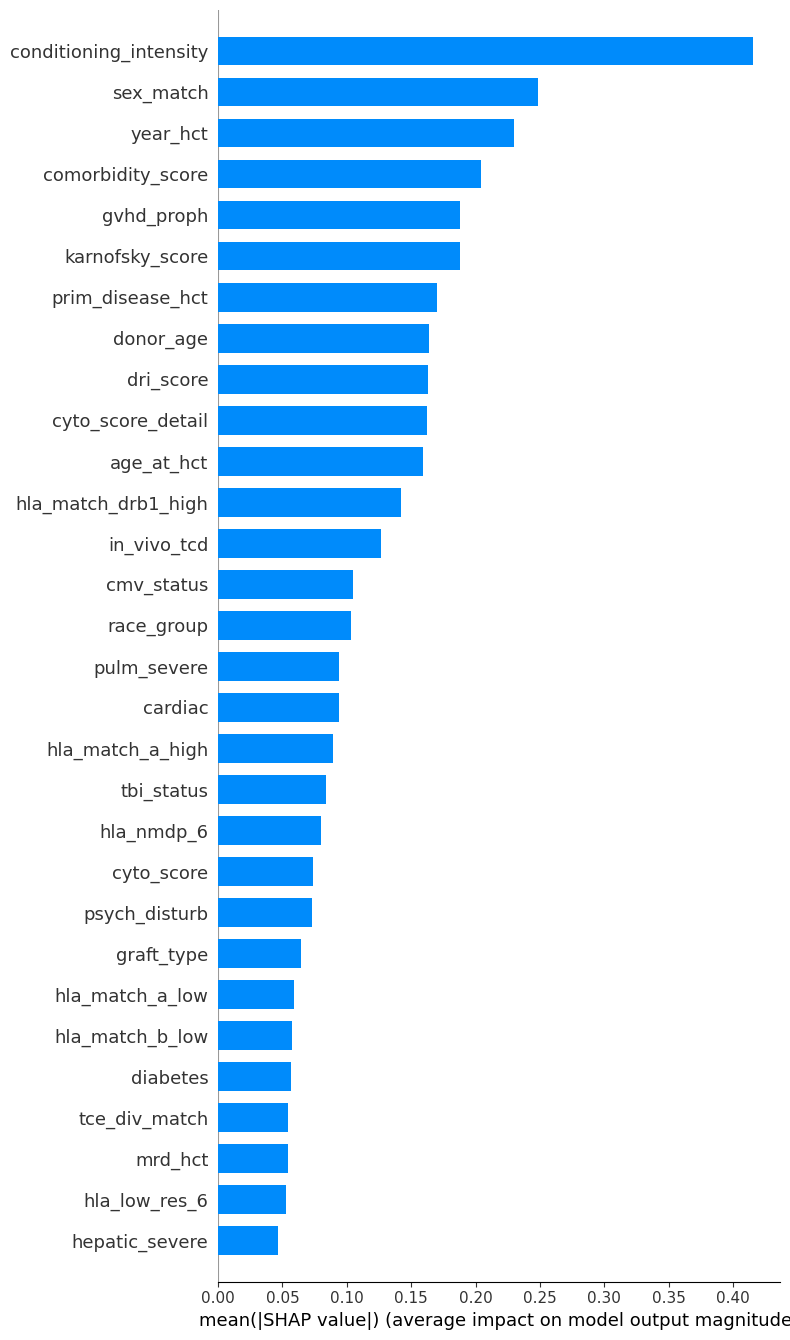

In [43]:
plot_shap(model=xgb_model, X_test=X_test)

In [48]:
# Train with Random Forest Classifier
X_train_no_nan = X_train.fillna(-1)
X_test_no_nan = X_test.fillna(-1)

rf_model = RandomForestClassifier()
rf_model.fit(X_train_no_nan, y_train)
rf_pred = rf_model.predict_proba(X_test_no_nan)[:, 1]
print("ROC AUC:", roc_auc_score(y_true=y_test, y_score=rf_pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ROC AUC: 0.7225717741807967


## Conduct Cross Validation

In [48]:
# Here, we would like to conduct cross validation to find the assumed best model
kf = KFold(n_splits=4)
list_scores = []
for train_idx, val_idx in kf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train with basic light GBDT Models
    cat_model = cat.CatBoostClassifier(verbose=0, cat_features=cat_cols)
    cat_model.fit(X_train, y_train)
    cat_pred = cat_model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_true=y_test, y_score=cat_pred)
    list_scores.append(score)
    print("ROC AUC:", score)
print("Average ROC AUC:", np.mean(list_scores))

ROC AUC: 0.7621463980814767
ROC AUC: 0.761991969559026
ROC AUC: 0.7518762560685763
ROC AUC: 0.7581129164777911
Average ROC AUC: nan


Mean of empty slice.
invalid value encountered in scalar divide


In [50]:
def conduct_cross_validation(model, X, y):
    """
    Conduct Cross Validation and Calculate Average ROC AUC Score
    """
    kf = KFold(n_splits=4)
    list_scores = []
    for train_idx, val_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train with basic light GBDT Models
        model.fit(X_train, y_train)
        pred_proba = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_true=y_test, y_score=pred_proba)
        list_scores.append(score)
        print("ROC AUC:", score)
    print("Average ROC AUC:", np.mean(list_scores))    

In [57]:
# CV by LightGBM
model_lgb = lgb.LGBMClassifier(verbose=0)
conduct_cross_validation(model=model_lgb, X=X, y=y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ROC AUC: 0.7478540143354895


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ROC AUC: 0.7491073137708056


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ROC AUC: 0.7414689635781575


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


ROC AUC: 0.7477349489203771
Average ROC AUC: 0.7465413101512075


In [58]:
# CV by XGBoost
model_xgb = xgb.XGBClassifier()
conduct_cross_validation(model=model_xgb, X=X, y=y)

ROC AUC: 0.7317838105603441
ROC AUC: 0.7315624343441418
ROC AUC: 0.7337712762478226
ROC AUC: 0.7303505630488789
Average ROC AUC: 0.7318670210502969


In [59]:
# CV by Catboost with categorical feature
cat_model_1 = cat.CatBoostClassifier(verbose=0, cat_features=cat_cols)
conduct_cross_validation(model=cat_model_1, X=X, y=y)

ROC AUC: 0.7621463980814767
ROC AUC: 0.761991969559026
ROC AUC: 0.7518762560685763
ROC AUC: 0.7581129164777911
Average ROC AUC: 0.7585318850467175


In [60]:
# CV by Catboost without categorical feature
cat_model_2 = cat.CatBoostClassifier(verbose=0)
conduct_cross_validation(model=cat_model_2, X=X, y=y)

ROC AUC: 0.7576216169867325
ROC AUC: 0.7556953879434444
ROC AUC: 0.7492740648246858
ROC AUC: 0.7576492159269924
Average ROC AUC: 0.7550600714204638


In [ ]:
# From the result above, I conclude that catboost would peroform the best, and it would be good to use cat_features parameter

## Explore Data

In [20]:
# The number of nan or Not Done values
df_train["count_nan_vals"] = df_train.isnull().sum(axis=1)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='count_nan_vals', ylabel='Count'>

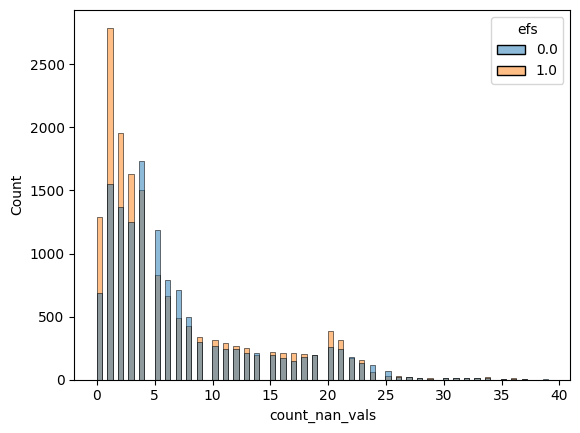

In [21]:
sns.histplot(data=df_train, x="count_nan_vals", hue="efs")

In [22]:
df_train.groupby("count_nan_vals")["efs"].mean()

count_nan_vals
0     0.652989
1     0.642578
2     0.587368
3     0.565520
4     0.464153
5     0.411881
6     0.456177
7     0.408299
8     0.458198
9     0.528951
10    0.538995
11    0.545627
12    0.519763
13    0.547414
14    0.485075
15    0.528708
16    0.554090
17    0.586592
18    0.529255
19    0.503876
20    0.595349
21    0.561717
22    0.489914
23    0.542254
24    0.331395
25    0.313725
26    0.600000
27    0.523810
28    0.428571
29    0.684211
30    0.583333
31    0.516129
32    0.458333
33    0.400000
34    0.629630
35    0.533333
36    0.714286
37    0.727273
39    0.000000
Name: efs, dtype: float64

In [ ]:
# The plot above indicates the more null values, the less the patients are likely to survive

In [16]:
df_train["count_not_done_vals"] = (df_train == "Not done").sum(axis=1)

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


<Axes: xlabel='count_not_done_vals', ylabel='Count'>

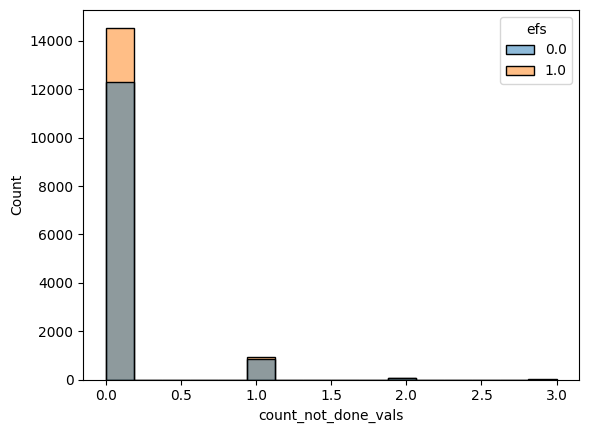

In [17]:
sns.histplot(data=df_train, x="count_not_done_vals", hue="efs")

In [18]:
# 
df_train.groupby("count_not_done_vals")["efs"].mean()

count_not_done_vals
0    0.541684
1    0.516973
2    0.379562
3    0.333333
Name: efs, dtype: float64

In [ ]:
# It seems that the more not done vals, the less the patients are likely to survive

In [36]:
!pip install jedi

In [37]:
%config Completer.use_jedi = True

In [ ]:
df_train.shape